In [1]:
import torch
import transformer_lens.utils as utils
import plotly.express as px
import tqdm
from functools import partial
import einops
import plotly.graph_objects as go
if torch.cuda.is_available():
    device = "cuda"
# elif torch.backends.mps.is_available():
#     device = "mps"
else: 
    device = "cpu"
torch.set_grad_enabled(False)
!nvidia-smi

import os

# Suppress tqdm progress bars
tqdm.tqdm().disable = True

os.environ['TOKENIZERS_PARALLELISM'] = 'false'
def test_performance(prompt_list, answer_list, model, max_new_tokens=1, temperature=0.4):
    tokens = model.to_tokens(prompt_list, prepend_bos=True)
    op = model.generate(tokens, max_new_tokens=1, temperature=0.4)
    corr = 0
    for ind, val in enumerate(prompt_list):
        # print("Prompt: "+val)
        # print("Expected Answer: "+answer_list[ind])
        # print("Model Answer: "+ model.to_string(op[ind, -1]))
        if answer_list[ind] == model.to_string(op[ind, -1]):
            corr+=1
    return corr*100/len(prompt_list)

import random
import string

def generate_sequences(num_samples, transitive_length, fake_prob=0.5, randomize_prob=0.5):
    sequences = []
    answers = []

    for _ in range(num_samples):
        # Generate transitive sequence letters
        transitive_letters = random.sample(string.ascii_uppercase, transitive_length + 1)
        
        # Create the transitive property sequence
        transitive_relations = [(transitive_letters[i], transitive_letters[i+1]) for i in range(transitive_length)]
        
        # Randomly shuffle the transitive relations based on randomize_prob
        if random.random() < randomize_prob:
            random.shuffle(transitive_relations)
        
        # Optionally add fake sequences based on fake_prob
        fake_sequences = []
        if random.random() < fake_prob:
            num_fake_sequences = random.randint(1, 2)  # Add 1 or 2 fake sequences
            for _ in range(num_fake_sequences):
                fake_letters = random.sample(string.ascii_uppercase, 2)
                while set(fake_letters).intersection(set(transitive_letters)):
                    fake_letters = random.sample(string.ascii_uppercase, 2)
                fake_sequences.append((fake_letters[0], fake_letters[1]))

        # Combine real and fake sequences and shuffle if needed
        all_relations = transitive_relations + fake_sequences
        if random.random() < randomize_prob:
            random.shuffle(all_relations)
        
        # Create the prompt
        prompt_parts = [f"{a} leads to {b}" for a, b in all_relations]
        prompt = f"If {', '.join(prompt_parts)}, then {transitive_letters[0]} will eventually lead to <strong>"
        
        # Append to results
        sequences.append(prompt)
        answers.append(transitive_letters[-1])

    return sequences, answers

# Example usage with knobs
prompts, answers = generate_sequences(50, 5, fake_prob=0, randomize_prob=0.8)

Sun Jul  7 23:19:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.08             Driver Version: 535.161.08   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:06:00.0 Off |                    0 |
| N/A   33C    P0              33W / 250W |      3MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

0it [00:00, ?it/s]

In [2]:
from sae_lens import HookedSAETransformer
model_gemma: HookedSAETransformer = HookedSAETransformer.from_pretrained("gemma-2b").to(device)

from sae_lens import SAE 
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes

# Choose a layer you want to focus on
# For this tutorial, we're going to use layer 2
layer = 6

# get the SAE for this layer
sae, cfg_dict, _ = SAE.from_pretrained(
    release = "gemma-2b-res-jb",
    sae_id = f"blocks.{layer}.hook_resid_post",
    device = device
)

# get hook point
hook_point = sae.cfg.hook_name
print(hook_point)

Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded pretrained model gemma-2b into HookedTransformer
Moving model to device:  cuda
blocks.6.hook_resid_post


In [3]:

def logit_difference(model, answers, prompts):
    # Convert prompts to tokens
    tokens = model.to_tokens(prompts)
    logits, _ = model.run_with_cache(tokens)
    
    # Get the correct tokens for all answers at once
    correct_tokens = model.to_tokens(answers).squeeze()[:, 1]  # Select the second token (correct token) in each sequence

    # Get the logits for the last token of each prompt
    last_logits = logits[:, -1, :]

    # Get the most probable token indices for all prompts at once
    most_probable_token_indices = torch.argmax(last_logits, dim=-1)

    # Gather the logits for the most probable tokens and the correct tokens
    most_probable_logits = last_logits.gather(1, most_probable_token_indices.unsqueeze(1)).squeeze(1)
    correct_logits = last_logits.gather(1, correct_tokens.unsqueeze(1)).squeeze(1)

    # Calculate the logit differences
    logit_differences = most_probable_logits - correct_logits
    return logit_differences

def logit_difference_steered(model, logits, answers, prompts):
    
    # Get the correct tokens for all answers at once
    correct_tokens = model.to_tokens(answers).squeeze()[:, 1]  # Select the second token (correct token) in each sequence

    # Get the logits for the last token of each prompt
    last_logits = logits[:, -1, :]

    # Get the most probable token indices for all prompts at once
    most_probable_token_indices = torch.argmax(last_logits, dim=-1)

    # Gather the logits for the most probable tokens and the correct tokens
    most_probable_logits = last_logits.gather(1, most_probable_token_indices.unsqueeze(1)).squeeze(1)
    correct_logits = last_logits.gather(1, correct_tokens.unsqueeze(1)).squeeze(1)

    # Calculate the logit differences
    logit_differences = most_probable_logits - correct_logits
    return logit_differences

In [4]:
code_prompt ="""
# Initialize spaCy NLP model
nlp = spacy.load('en_core_web_sm')

def fetch_webpage(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        return None

def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

def store_entities(entities):
    conn = sqlite3.connect('entities.db')
    c = conn.cursor()
    c.execute('''CREATE TABLE IF NOT EXISTS Entities (text TEXT, label TEXT)''')
    c.executemany('INSERT INTO Entities (text, label) VALUES (?, ?)', entities)
    conn.commit()
    conn.close()

# Example URL to test the functionality
example_url = 'https://en.wikipedia.org/wiki/Natural_language_processing'
main(example_url)
"""

In [5]:
sv_prompt = code_prompt
sv_logits, cache = model_gemma.run_with_cache(sv_prompt, prepend_bos=True)
tokens = model_gemma.to_tokens(sv_prompt)

# get the feature activations from our SAE
sv_feature_acts = sae.encode(cache[hook_point])

# get sae_out
sae_out = sae.decode(sv_feature_acts)


tensor([[     2,    108, 235345,  26768,   9878,  10687, 117549,   2091,    108,
         131242,    589, 224991, 235265,   1705,   1101,    479, 235298,   2309,
         235298,   4405, 235298,   3913,   1685,    109,   1293,  17154, 235298,
           4405,   3323, 235278,   2457,   1245,    108,    141,   4250,    589,
          12557, 235265,    818, 235278,   2457, 235275,    108,    141,    648,
           3590, 235265,   3325, 235298,   2564,   1159, 235248, 235284, 235276,
         235276, 235292,    108,    145,    773,   3590, 235265,   1082,    108,
            141,   1075, 235292,    108,    145,    773,   4090,    109,   1293,
          16787, 235298,  19460, 235278,   1082,   1245,    108,    141,   3028,
            589,    552,  20603, 235278,   1082, 235275,    108,    141,  19460,
            589,  52574,    579, 235265,   1082, 235269,   2160, 235265,   2097,
          28432,    604,   2160,    575,   2865, 235265,    990, 235307,    108,
            141,    773,  26

In [22]:
top_features = torch.topk(sv_feature_acts, 10).indices.tolist()

In [23]:
from collections import Counter

def sort_by_frequency(nested_list):
    # Flatten the nested list
    flat_list = [item for sublist in nested_list for item in sublist]
    
    # Count the frequency of each element
    frequency_count = Counter(flat_list)
    # Sort elements by frequency (most frequent first) and then by the element value (if frequencies are the same)
    sorted_elements = sorted(frequency_count.keys(), key=lambda x: (-frequency_count[x], x))
    
    return sorted_elements

sorted_unique_elements = sort_by_frequency(top_features[0])
print(len(sorted_unique_elements))

752


In [24]:
sorted_unique_elements[:5]

[11631, 5439, 15417, 15617, 3392]

In [12]:
result_dict = {}
steering_on = True
for feature_ind in sorted_unique_elements[:100]:
    coeff_dict = {}
    for coeff in [5, 50, 150]:
        # dict_key = str(feature_ind)+"_"+str(coeff)
        steering_vector = sae.W_dec[feature_ind]
        def steering_hook(resid_pre, hook):
            if resid_pre.shape[1] == 1:
                return

            position = sae_out.shape[1]
            if steering_on:
              # using our steering vector and applying the coefficient
              resid_pre[:, :position - 1, :] += coeff * steering_vector

        def hooked_generate(prompt_batch, fwd_hooks=[], seed=None):
            if seed is not None:
                torch.manual_seed(seed)

            with model_gemma.hooks(fwd_hooks=fwd_hooks):
                tokenized = model_gemma.to_tokens(prompt_batch)
                result, _ = model_gemma.run_with_cache(tokenized)
            return result
        
        model_gemma.reset_hooks()
        editing_hooks = [(f"blocks.{layer}.hook_resid_post", steering_hook)]
        logits = hooked_generate(prompts, editing_hooks, seed=None)
        coeff_dict[coeff] = logit_difference_steered(model_gemma, logits, answers, prompts)
        # Free up memory
        del logits
        torch.cuda.empty_cache()
    result_dict[feature_ind] = coeff_dict 

In [ ]:
result_dict

In [17]:
base_logit_diff = logit_difference(model_gemma, answers, prompts)
baseline_avg = base_logit_diff.mean().item()

/tmp/ipykernel_1627348/2437817026.py:37: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


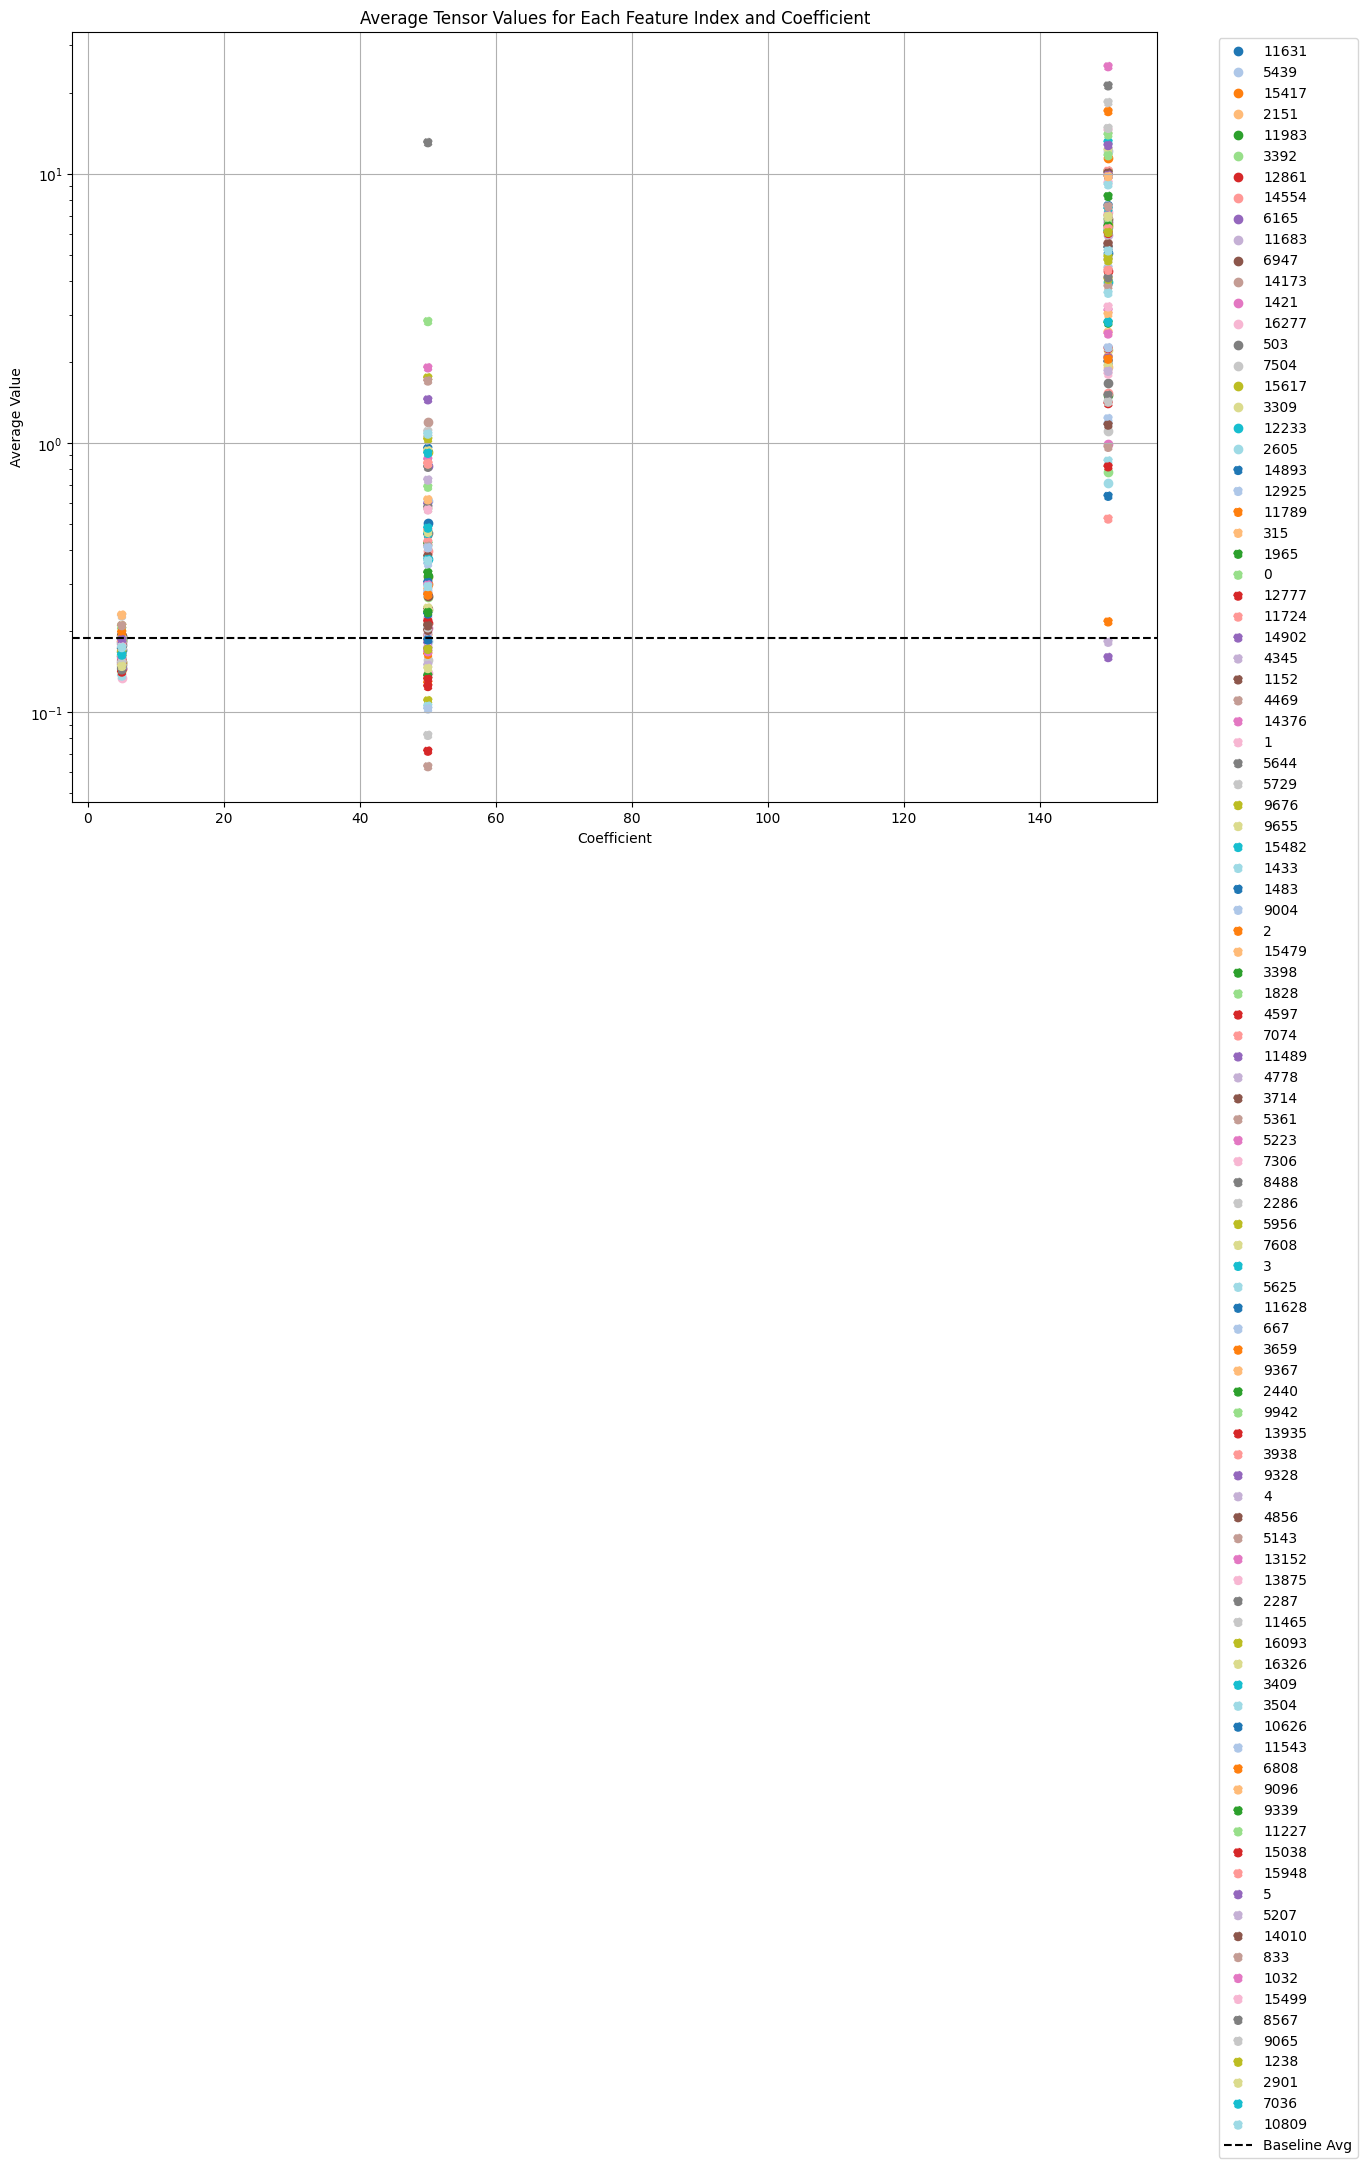

In [18]:
import matplotlib.pyplot as plt
# Dictionary to store average values
avg_dict = {}

# Calculate averages
for feature_ind, coeff_dict in result_dict.items():
    avg_dict[feature_ind] = {}
    for coeff, tensor in coeff_dict.items():
        avg_dict[feature_ind][coeff] = tensor.mean().item()


# Plotting
plt.figure(figsize=(14, 10))

# Create a colormap
cmap = plt.get_cmap('tab20')  # You can choose other colormaps if needed
num_colors = 20  # Adjust based on the chosen colormap

for idx, (feature_ind, coeff_dict) in enumerate(avg_dict.items()):
    coeffs = list(coeff_dict.keys())
    averages = list(coeff_dict.values())
    
    color = cmap(idx % num_colors)
    linestyle = '-' if idx < num_colors else '--'
    
    plt.scatter(coeffs, averages, label=feature_ind, color=color, linestyle=linestyle, marker='o')

# Plot baseline average value
plt.axhline(y=baseline_avg, color='k', linestyle='--', label='Baseline Avg')

plt.xlabel('Coefficient')
plt.ylabel('Average Value')
plt.yscale("log")
plt.title('Average Tensor Values for Each Feature Index and Coefficient')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Find the N feature indices with the lowest averages
N = 15  # Number of lowest averages to find
feature_min_avg_list = []

for feature_ind, coeff_dict in avg_dict.items():
    min_avg_value = min(coeff_dict.values())
    feature_min_avg_list.append((feature_ind, min_avg_value))

# Sort the features by their minimum average values
feature_min_avg_list.sort(key=lambda x: x[1])

# Get the N lowest averages
lowest_avg_features = feature_min_avg_list[:N]

print(f"The {N} feature indices with the lowest minimum average values are:")
for feature_ind, avg_value in lowest_avg_features:
    print(f"{feature_ind}: {avg_value}")



The 15 feature indices with the lowest minimum average values are:
5361: 0.06287036836147308
13935: 0.0717906579375267
9065: 0.08217113465070724
9004: 0.1029750406742096
1433: 0.10541900247335434
9676: 0.11046523600816727
12777: 0.12480189651250839
11789: 0.12867629528045654
15038: 0.13271564245224
7306: 0.13361255824565887
16277: 0.1336352825164795
5625: 0.13646326959133148
9339: 0.13668189942836761
7608: 0.1395479142665863
8567: 0.1438824087381363


In [28]:
code_features = [11631, 5439, 15417, 15617, 3392]

In [31]:
for feature_ind, avg_value in avg_dict.items():
    if feature_ind in code_features:
        print(f"{feature_ind}: {avg_value}")

11631: {5: 0.17010478675365448, 50: 0.50413578748703, 150: 5.078768730163574}
5439: {5: 0.1534852534532547, 50: 0.6099527478218079, 150: 12.113359451293945}
15417: {5: 0.14436812698841095, 50: 0.29942676424980164, 150: 11.483781814575195}
3392: {5: 0.18330185115337372, 50: 0.26747190952301025, 150: 0.7830897569656372}
15617: {5: 0.15343379974365234, 50: 0.9223527312278748, 150: 6.448155403137207}


In [32]:
baseline_avg

0.18881873786449432